In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect =True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Create the inspector and connect it to the engine (checking the type of data in each table)
inspector = inspect(engine)

In [10]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#create the metadata object:
meta_data = db.MetaData(bind = engine)
db.MetaData.reflect(meta_data)

In [13]:
# getting query to find out the latest date by using Max function
query = db.select([measurement.id, measurement.station, measurement.prcp, measurement.tobs, db.func.max(measurement.date)])

In [14]:
#fetch all the records
result = engine.execute(query).fetchall()

# view the records/ Find the most recent date in the data set.
for record in result:
    print ("\n", record)


 (2723, 'USC00519397', 0.0, 27.2, '2017-08-23')


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_12_mth = dt.date(2017,8,23) - dt.timedelta(365)
print (f'The date one year ago from the last date in data set is: {query_12_mth}')

The date one year ago from the last date in data set is: 2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
retrieve_data = session.query(measurement.prcp, measurement.date).filter(measurement.date > '2016-08-22').filter(measurement.date <= '2017-08-23').order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
convert_data = pd.DataFrame(retrieve_data, columns=["Precipitation", "date"])
convert_data = convert_data[["date", "Precipitation"]].set_index("date")

# Sort the dataframe by date
sort_data = convert_data.sort_index (ascending= True)

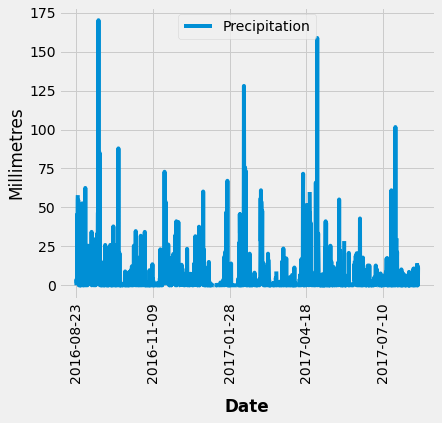

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
sort_data.plot (figsize =(6,5), use_index=True, rot =90)
plt.xlabel ("Date", labelpad= 15, weight = 'bold')
plt.ylabel ("Millimetres")


plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_stats = (sort_data['Precipitation'].to_frame()).describe()
precipitation_stats


,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(func.count(measurement.station.distinct())).first()[0]
number_stations

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
most_active_station = active_stations[0]

print ("The most active station is: " + most_active_station[0] + " with the most rows number of: "+ f'{most_active_station[1]}')

The most active station is: USC00519281 with the most rows number of: 2772


In [22]:
# Using the most active station id from the previous query, calculate the lowest temperature of the most active station over the past 12 months
min_temp = session.query(func.min(measurement.tobs), measurement.station).filter(measurement.date > '2016-08-22')\
    .filter(measurement.date <= '2017-08-23').filter(measurement.station ==most_active_station[0]).all()

print (f'The lowest temperature of the most active station over the past 12 months is: {min_temp[0][0]} Celcius')


The lowest temperature of the most active station over the past 12 months is: 15.0 Celcius


In [23]:
# Using the most active station id from the previous query, calculate the highest temperature of the most active station over the past 12 months
max_temp = session.query(func.max(measurement.tobs), measurement.station).filter(measurement.date > '2016-08-22')\
    .filter(measurement.date <= '2017-08-23').filter(measurement.station ==most_active_station[0]).all()

print (f'The lowest temperature of the most active station over the past 12 months is: {max_temp[0][0]} Celcius')

The lowest temperature of the most active station over the past 12 months is: 28.3 Celcius


In [24]:
# Using the most active station id from the previous query, calculate the average temperature of the most active station over the past 12 months
avg_temp = session.query(func.avg(measurement.tobs), measurement.station).filter(measurement.date > '2016-08-22')\
    .filter(measurement.date <= '2017-08-23').filter(measurement.station ==most_active_station[0]).all()

print (f'The lowest temperature of the most active station over the past 12 months is: {round(avg_temp[0][0],2)} Celcius')

The lowest temperature of the most active station over the past 12 months is: 22.84 Celcius


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_histogram = session.query(measurement.tobs, measurement.station).filter(measurement.date > '2016-08-22')\
    .filter(measurement.date <= '2017-08-23').filter(measurement.station ==most_active_station[0]).all()

In [26]:
#convert to DataFrame for plotting
tobs_histogram = pd.DataFrame(tobs_histogram, columns= ["Temperature Observation", "Station"])
tobs_histogram

,Temperature Observation,Station
0,25.0,USC00519281
1,25.0,USC00519281
2,26.7,USC00519281
3,26.7,USC00519281
4,23.9,USC00519281
...,...,...
347,25.0,USC00519281
348,25.0,USC00519281
349,24.4,USC00519281
350,24.4,USC00519281


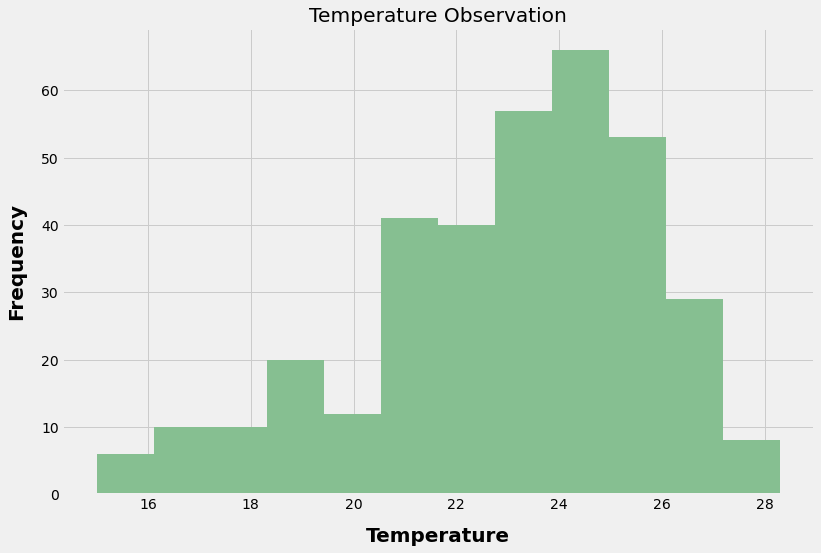

In [27]:
#plotting a historgram with bins = 12
ax = tobs_histogram.hist(column="Temperature Observation", bins =12, figsize=(12,8),color='#86bf91', zorder=2)

#Set x-axis label
plt.xlabel ("Temperature", labelpad = 15, weight = 'bold', size = 20)

#set y-axis label
plt.ylabel ("Frequency", labelpad=15, weight ='bold', size = 20)

plt.show()

# Close session

In [28]:
# Close Session
session.close()